# Develop an initial model

In [1]:
# Python modules
import dateutil
from datetime import datetime
import re

# Data science packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit Learn utility classes & functions
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error

# Scikit Learn models
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.ensemble import (AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor,
                              RandomForestRegressor)
from sklearn.svm import SVR, LinearSVR
from xgboost import XGBRegressor

# Our own code
from src.data.preprocessing import betting_model_df, team_betting_model_df, cum_team_df
from src.model.metrics import measure_estimators, regression_accuracy

np.random.seed(42)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Set up data and create cumulative features

model_df = betting_model_df()
team_df = team_betting_model_df(model_df)
cum_df = cum_team_df(team_df)
cum_df

team         oppo_team  score  \
team             year round_number                                              
Adelaide         2010 2                     Adelaide            Sydney   75.0   
                      3                     Adelaide         Melbourne   41.0   
                      4                     Adelaide           Carlton   55.0   
                      5                     Adelaide  Western Bulldogs   72.0   
                      6                     Adelaide     Port Adelaide   74.0   
                      7                     Adelaide          Richmond  104.0   
                      8                     Adelaide   North Melbourne   75.0   
                      9                     Adelaide          Brisbane   93.0   
                      10                    Adelaide          St Kilda   76.0   
                      11                    Adelaide         Fremantle  105.0   
                      12                    Adelaide          Hawthorn   77.0   
                      13                    Adelaide         Melbourne  117.0   
                      14                    Adelaide          Essendon  124.0   
                      15                    Adelaide        West Coast  117.0   
                      16                    Adelaide           Geelong   74.0   
                      17                    Adelaide     Port Adelaide   69.0   
                      18                    Adelaide          Richmond   80.0   
                      19                    Adelaide  Western Bulldogs   53.0   
                      20                    Adelaide          Brisbane  104.0   
                      21                    Adelaide       Collingwood   51.0   
                      22                    Adelaide          St Kilda   65.0   
                 2011 1                     Adelaide          Hawthorn  105.0   
                      3                     Adelaide         Fremantle   54.0   
                      4                     Adelaide     Port Adelaide   66.0   
                      5                     Adelaide           Carlton   79.0   
                      6                     Adelaide          St Kilda   90.0   
                      7                     Adelaide         Melbourne   53.0   
                      8                     Adelaide        Gold Coast  130.0   
                      9                     Adelaide       Collingwood   92.0   
                      10                    Adelaide          Brisbane   61.0   
...                                              ...               ...    ...   
Western Bulldogs 2015 21            Western Bulldogs        West Coast   85.0   
                      22            Western Bulldogs   North Melbourne   96.0   
                      23            Western Bulldogs          Brisbane  122.0   
                      25            Western Bulldogs          Adelaide  102.0   
                 2016 1             Western Bulldogs         Fremantle  103.0   
                      2             Western Bulldogs          St Kilda   93.0   
                      3             Western Bulldogs          Hawthorn   90.0   
                      4             Western Bulldogs           Carlton   85.0   
                      5             Western Bulldogs          Brisbane  120.0   
                      6             Western Bulldogs   North Melbourne   45.0   
                      7             Western Bulldogs          Adelaide  123.0   
                      8             Western Bulldogs         Melbourne  114.0   
                      9             Western Bulldogs               GWS   73.0   
                      10            Western Bulldogs       Collingwood   74.0   
                      11            Western Bulldogs        West Coast   83.0   
                      12            Western Bulldogs     Port Adelaide  100.0   
                      13            Western Bulldogs           Geelong   43.0  

## Which models perform better on betting/match data?

In [3]:
# Set up & split data for models

team_features = pd.get_dummies(cum_df.drop(['score', 'oppo_score'], axis=1))
team_labels = pd.Series(cum_df['score'] - cum_df['oppo_score'], name='score_diff')
data = train_test_split(team_features, team_labels)

In [4]:
# Pass data to models & measure performance

linear = (Lasso(), ElasticNet(), Ridge(), LinearSVR())
print('LINEAR')
linear_scores = measure_estimators(linear, data, model_type='regression')

ensemble = (AdaBoostRegressor(),
            BaggingRegressor(),
            ExtraTreesRegressor(),
            GradientBoostingRegressor(),
            RandomForestRegressor(),
            SVR(kernel='rbf'),
            XGBRegressor())
print('\n\nENSEMBLE')
ensemble_scores = measure_estimators(ensemble, data, model_type='regression')

LINEAR


Lasso
Mean CV accuracy: 0.7209285046886785
Test accuracy: 0.7183499288762447

Mean CV negative error score: 28.897908400852863
Test error score: 28.64304532689878


ElasticNet
Mean CV accuracy: 0.7195033265414101
Test accuracy: 0.7240398293029872

Mean CV negative error score: 29.089270014934037
Test error score: 28.856995118787985


Ridge
Mean CV accuracy: 0.7213968096722991
Test accuracy: 0.7240398293029872

Mean CV negative error score: 29.121108059119486
Test error score: 28.718858616190325


LinearSVR
Mean CV accuracy: 0.7171336582949646
Test accuracy: 0.7283072546230441

Mean CV negative error score: 29.276223203408637
Test error score: 28.961131927970424


ENSEMBLE


AdaBoostRegressor
Mean CV accuracy: 0.7171280296292961
Test accuracy: 0.7211948790896159

Mean CV negative error score: 29.32587264130846
Test error score: 29.060504479245804


BaggingRegressor
Mean CV accuracy: 0.6943578255338789
Test accuracy: 0.6927453769559033

Mean CV negative error score: 31.105863718

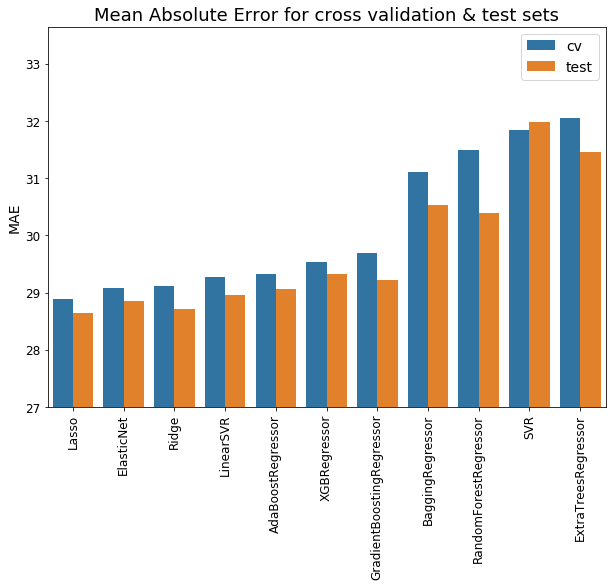

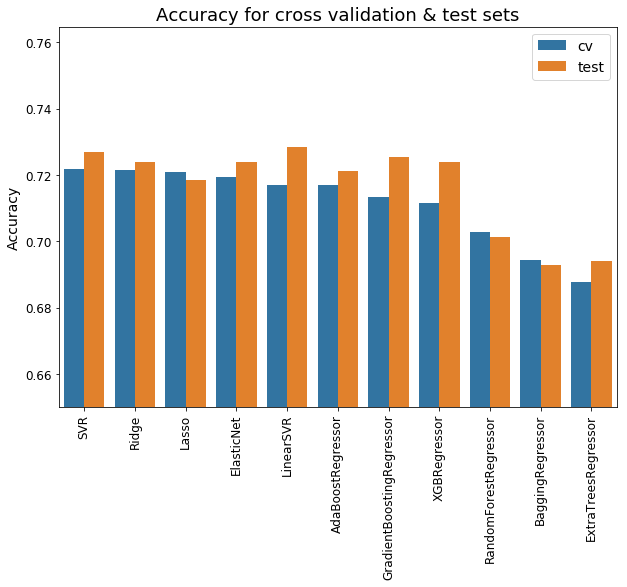

In [5]:
# MAE scores
mae_scores = linear_scores.append(ensemble_scores).sort_values(['score_type', 'error'], ascending=[True, True])

plt.figure(figsize=(10, 7))
sns.barplot(x='estimator', y='error', hue='score_type', data=mae_scores)
plt.ylim(ymin=27)
plt.title('Mean Absolute Error for cross validation & test sets', fontsize=18)
plt.ylabel('MAE', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(fontsize=14)

plt.show()

# Accuracy scores
acc_scores = mae_scores.sort_values(['score_type', 'accuracy'], ascending=[True, False])

plt.figure(figsize=(10, 7))
sns.barplot(x='estimator', y='accuracy', hue='score_type', data=acc_scores)
plt.ylim(ymin=0.65)
plt.title('Accuracy for cross validation & test sets', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(fontsize=14)

plt.show()

### Linear models perform better than ensembles

The 'boost' ensembles have comparable performance to the better linear models, but all the linear models get around 29 MAE for both the CV and test scores, with Lasso having the best error scores and Ridge having the 3rd best error and 2nd best accuracy (SVR has terrible error, but the best CV accuracy for some reason).

## Does reducing the number of features make a difference?

In [6]:
# Try a stripped-down set of features to see if certain models are over-fitting and perform better with fewer features
# relative to other models

min_features = pd.get_dummies(cum_df[['team', 'oppo_team', 'line_odds', 'year', 'round_number', 'at_home']])

X_train, X_test = data[:2]
train_index = X_train.index
test_index = X_test.index

min_data = (min_features.loc[train_index, :],
            min_features.loc[test_index, :],
            data[2],
            data[3])

print('LINEAR')
min_linear_scores = measure_estimators(linear, min_data, model_type='regression')
print('\n\nENSEMBLE')
min_ensemble_scores = measure_estimators(ensemble, min_data, model_type='regression')

LINEAR


Lasso
Mean CV accuracy: 0.7228253650189688
Test accuracy: 0.7183499288762447

Mean CV negative error score: 28.8180592290363
Test error score: 28.639058992364202


ElasticNet
Mean CV accuracy: 0.7247267282817935
Test accuracy: 0.7155049786628734

Mean CV negative error score: 29.721420640004673
Test error score: 30.056053363138172


Ridge
Mean CV accuracy: 0.7209296304218122
Test accuracy: 0.7155049786628734

Mean CV negative error score: 29.0030239676097
Test error score: 28.839875524221277


LinearSVR
Mean CV accuracy: 0.7161869167295201
Test accuracy: 0.7211948790896159

Mean CV negative error score: 29.103007406334946
Test error score: 29.007959635284376


ENSEMBLE


AdaBoostRegressor
Mean CV accuracy: 0.7180837770598101
Test accuracy: 0.7254623044096729

Mean CV negative error score: 29.33245215265884
Test error score: 29.083744633126486


BaggingRegressor
Mean CV accuracy: 0.6867625040807825
Test accuracy: 0.6884779516358464

Mean CV negative error score: 31.757501660456

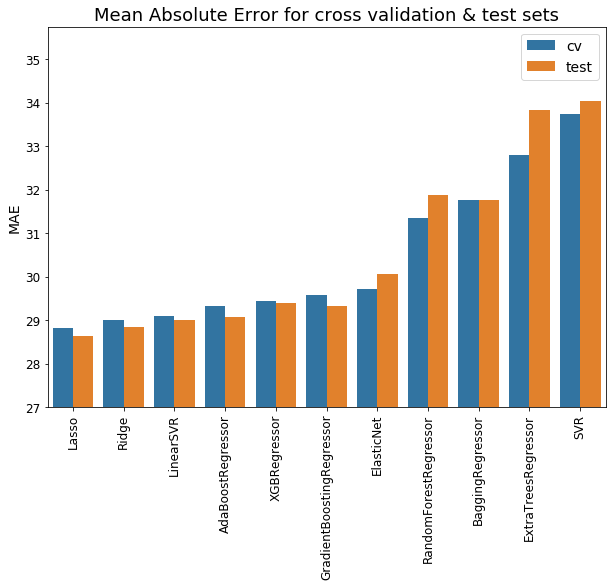

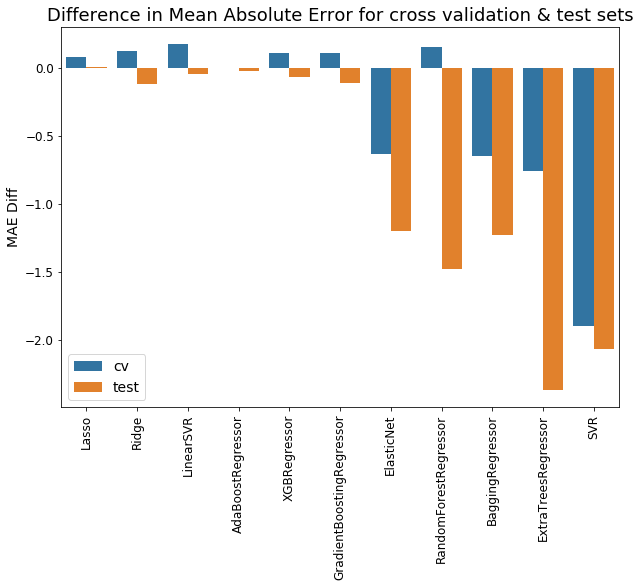

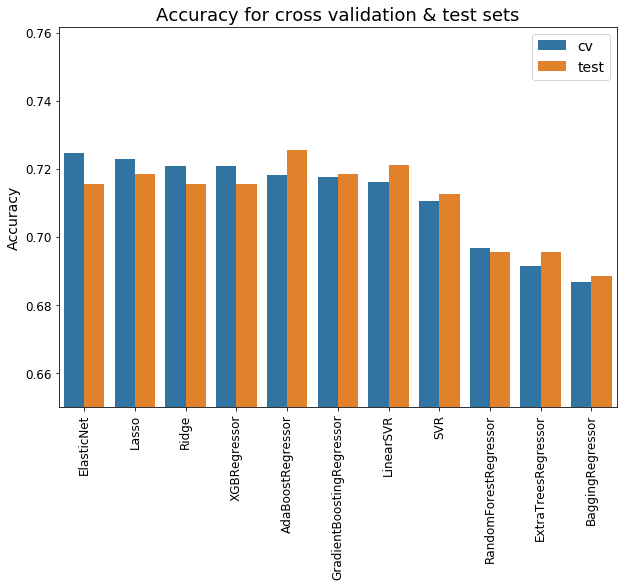

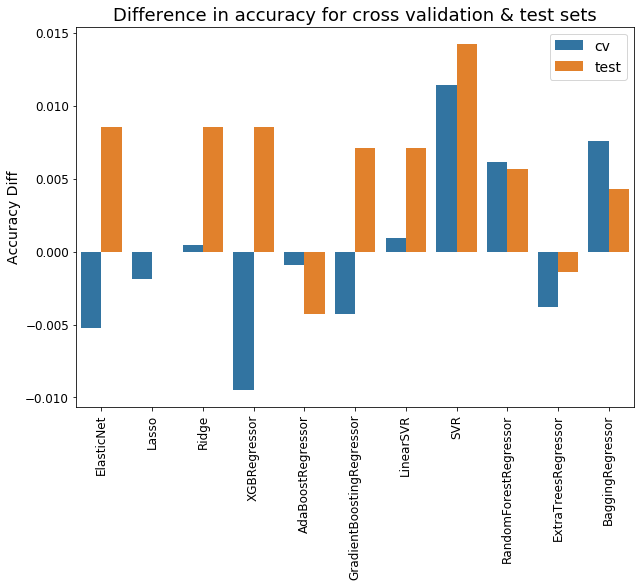

In [7]:
# MAE scores
min_mae_scores = (min_linear_scores.append(min_ensemble_scores)
                               .merge(mae_scores, on=['estimator', 'score_type'], suffixes=('', '_min'))
                               .assign(error_diff=lambda x: x['error_min'] - x['error'],
                                       accuracy_diff=lambda x: x['accuracy_min'] - x['accuracy'])
                               .sort_values(['score_type', 'error'], ascending=[True, True]))

plt.figure(figsize=(10, 7))
sns.barplot(x='estimator', y='error', hue='score_type', data=min_mae_scores)
plt.ylim(ymin=27)
plt.title('Mean Absolute Error for cross validation & test sets', fontsize=18)
plt.ylabel('MAE', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(fontsize=14)

plt.show()

plt.figure(figsize=(10, 7))
sns.barplot(x='estimator', y='error_diff', hue='score_type', data=min_mae_scores)
plt.title('Difference in Mean Absolute Error for cross validation & test sets', fontsize=18)
plt.ylabel('MAE Diff', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(fontsize=14)

plt.show()

# Accuracy scores
min_acc_scores = min_mae_scores.sort_values(['score_type', 'accuracy'], ascending=[True, False])

plt.figure(figsize=(10, 7))
sns.barplot(x='estimator', y='accuracy', hue='score_type', data=min_acc_scores)
plt.ylim(ymin=0.65)
plt.title('Accuracy for cross validation & test sets', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(fontsize=14)

plt.show()

plt.figure(figsize=(10, 7))
sns.barplot(x='estimator', y='accuracy_diff', hue='score_type', data=min_acc_scores)
plt.title('Difference in accuracy for cross validation & test sets', fontsize=18)
plt.ylabel('Accuracy Diff', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(fontsize=14)

plt.show()

### Linear models are still the best

Even with fewer features to prevent the ensemble models from overfitting, the linear models tend to perform better, and Lasso is still best-performing. It does improve performance on the test set for most models, so we'll want to remove or compress features as part of our model tuning.

## Is Lasso, ElasticNet, or Ridge better?

Lasso and ElasticNet generally have the lowest MAE scores and are in the top half for accuracy. Ridge has worse CV scores but particularly good test set scores, which means it either generalises very well or is just lucky with the train/test splits. AdaBoost has a decent MAE and the best accuracy.

In [8]:
# Round 24 represents first finals round and doesn't count for tipping competitions
tipping_features = team_features[team_features['round_number'] < 25]
tipping_labels = team_labels[tipping_features.index.values]

lasso = make_pipeline(StandardScaler(), Lasso())
en = make_pipeline(StandardScaler(), ElasticNet())
ridge = make_pipeline(StandardScaler(), Ridge())

estimators = (lasso, en, ridge)

model_names = []
errors = []
accuracies = []
years = []

for year in range(2011, 2017):
    X_train = tipping_features[tipping_features['year'] < year]
    X_test = tipping_features[tipping_features['year'] == year]
    y_train = tipping_labels.loc[X_train.index]
    y_test = tipping_labels.loc[X_test.index]
    
    for estimator in estimators:
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)

        years.append(year)
        model_names.append(estimator.steps[-1][0])
        errors.append(mean_absolute_error(y_test, y_pred))
        accuracies.append(regression_accuracy(y_test, y_pred))
        
year_scores = pd.DataFrame({'model': model_names,
                            'year': years,
                            'error': errors,
                            'accuracy': accuracies})
year_scores

,model,year,error,accuracy
0,lasso,2011,29.946754,0.755376
1,elasticnet,2011,29.944986,0.750000
2,ridge,2011,40.620346,0.626344
3,lasso,2012,29.745947,0.761421
4,elasticnet,2012,29.814905,0.776650
5,ridge,2012,31.548045,0.761421
6,lasso,2013,26.464631,0.732323
7,elasticnet,2013,26.745251,0.709596
8,ridge,2013,27.478250,0.719697
9,lasso,2014,28.042089,0.712121


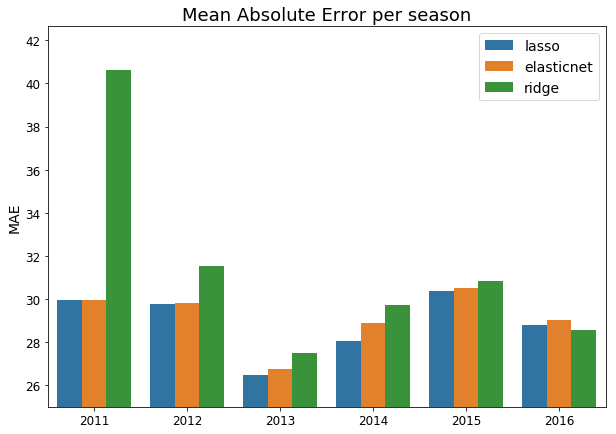

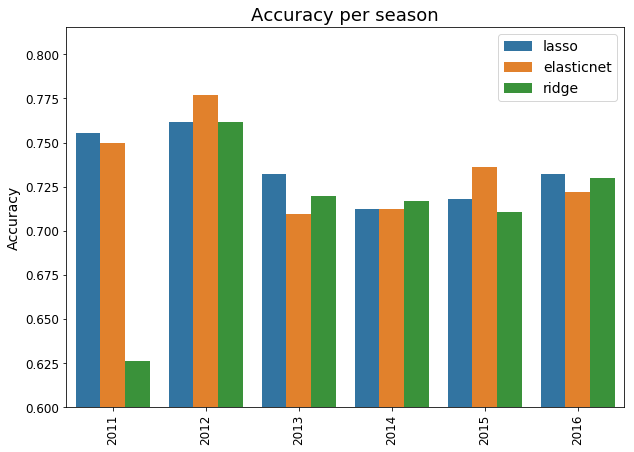

In [9]:
# MAE scores
plt.figure(figsize=(10, 7))
sns.barplot(x='year', y='error', hue='model', data=year_scores)
# Not starting axis at 0 to make small relative differences clearer
plt.ylim(ymin=25)
plt.title('Mean Absolute Error per season', fontsize=18)
plt.ylabel('MAE', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=14)

plt.show()

# Accuracy scores
plt.figure(figsize=(10, 7))
sns.barplot(x='year', y='accuracy', hue='model', data=year_scores)
# Not starting axis at 0 to make small relative differences clearer
plt.ylim(ymin=0.60)
plt.title('Accuracy per season', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(fontsize=14)

plt.show()

### Lasso is the best model

Lasso has the lowest MAE 4 out of 6 seasons. As shown in other comparisons, accuracy is a bit more random, resulting in a wider spread of winners: Lasso is most accurate for 3 seasons, Ridge for 2, and ElasticNet for 1.

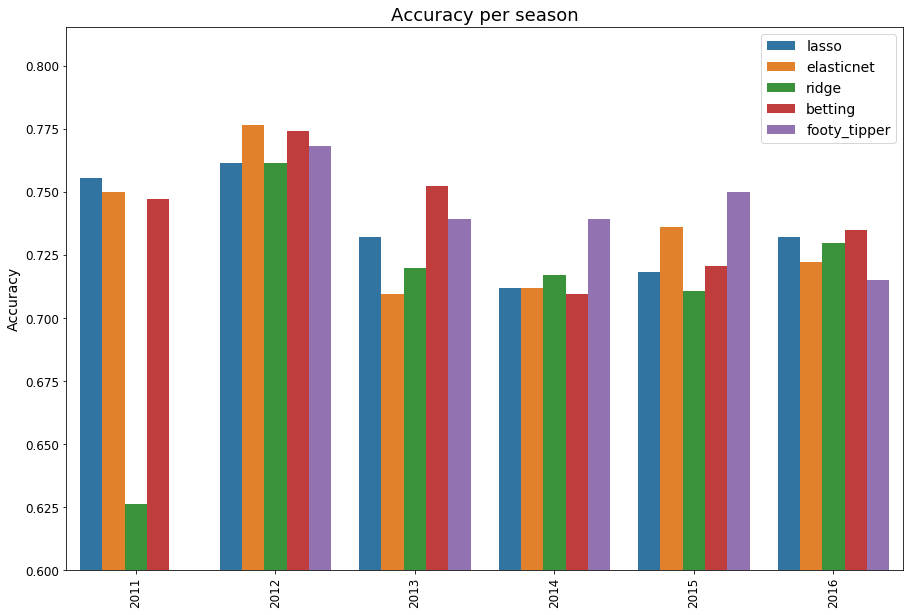

In [10]:
# Accuracy scores with betting accuracy & footy tipper

betting_scores = (((cum_df['line_odds'] < 0) & (cum_df['score'] >= cum_df['oppo_score']) |
                   (cum_df['line_odds'] > 0) & (cum_df['score'] <= cum_df['oppo_score']))
                  .loc[tipping_features[tipping_features['year'] > 2010].index.values]
                  .rename('accuracy')
                  .groupby(level=1)
                  .mean()
                  .reset_index()
                  .assign(model='betting', error=0))
# Footy tipper accuracy scores taken from a trial that took too long to run,
# so I'm just copy pasting from a notebook
footy_tipper_scores = pd.DataFrame({'model': ['footy_tipper'] * len(range(2012, 2017)),
                                    'year': list(range(2012, 2017)),
                                    'error': [0] * len(range(2012, 2017)),
                                    'accuracy': [0.768116, 0.739130, 0.739130, 0.750000, 0.714976]})

plt.figure(figsize=(15, 10))
sns.barplot(x='year',
            y='accuracy',
            hue='model',
            data=year_scores.append([betting_scores, footy_tipper_scores], sort=False))
# Not starting axis at 0 to make small relative differences clearer
plt.ylim(ymin=0.6)
plt.title('Accuracy per season', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(fontsize=14)

plt.show()

Even without any tuning, a lasso model performs reasonably well, beating the betting odds in 2 seasons (vs 2 for Footy Tipper and 3 for ElasticNet interestingly) and beating the fully-tuned Footy Tipper ensemble 1 out of 5 times (with Ridge beating it twice). Pretty good start.

Winners: Lasso, ElasticNet, Betting, FootyTipper, FootyTipper, Betting

2nd: ElasticNet, Betting, FootyTipper, Ridge, ElasticNet, Lasso

There is some evidence in the season breakdown to suggest that ElasticNet will perform better on a per-season basis, but the sample size is pretty small, and MAE is a more-reliable metric for model quality as (per the MoS blog post) accuracy suffers from much higher variance.